<h1>Autoencoder - Classificação de ECG</h1>

<h3>Importação de Biliotecas</h3>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

<h3>Carregando o Dataset</h3>

<p>Informações sobre o dataset encontram-se neste <a href="http://www.timeseriesclassification.com/description.php?Dataset=ECG5000">link</a>.</p>

<p><strong>Legenda da coluna 140:</strong>
<br/>
1 - Normal
<br/>
0 - Anômalo</p>

In [7]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


<h3>Pré-processamento</h3>

In [8]:
labels = raw_data[:, -1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [9]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [10]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

<h3>Estudo do dataset</h3>

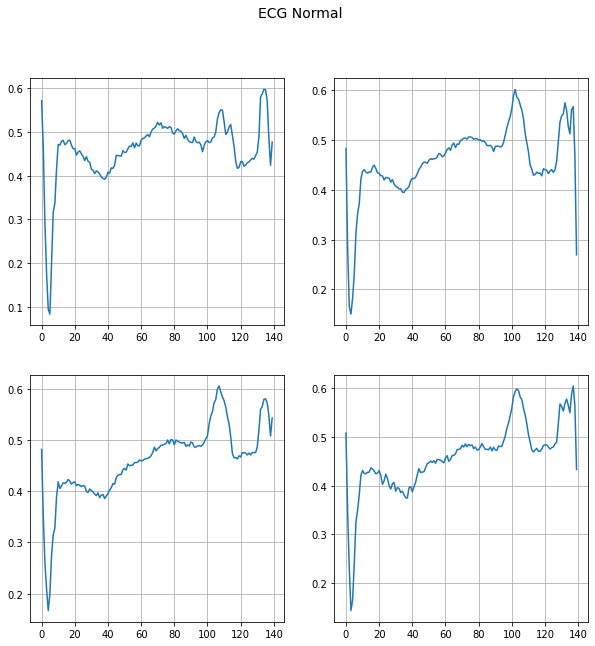

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.grid()
ax1.plot(np.arange(140), normal_train_data[0])
ax2.grid()
ax2.plot(np.arange(140), normal_train_data[1])
ax3.grid()
ax3.plot(np.arange(140), normal_train_data[2])
ax4.grid()
ax4.plot(np.arange(140), normal_train_data[3])
fig.suptitle("ECG Normal", fontsize=14)
plt.show()

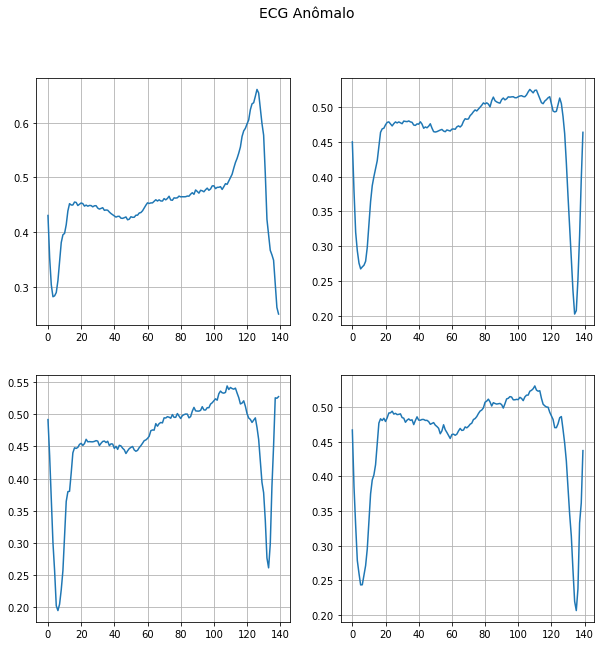

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.grid()
ax1.plot(np.arange(140), anomalous_train_data[0])
ax2.grid()
ax2.plot(np.arange(140), anomalous_train_data[1])
ax3.grid()
ax3.plot(np.arange(140), anomalous_train_data[2])
ax4.grid()
ax4.plot(np.arange(140), anomalous_train_data[3])
fig.suptitle("ECG Anômalo", fontsize=14)
plt.show()

<h3>Inicialização do autoencoder</h3>

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [14]:
autoencoder.compile(optimizer='adam', loss='mae')

<h3>Treinamento do autoencoder</h3>

In [15]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 96ms/step - loss: 0.0612 - val_loss: 0.0539
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0572 - val_loss: 0.0528
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0556 - val_loss: 0.0510
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0528 - val_loss: 0.0497
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0496 - val_loss: 0.0478
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0420 - val_loss: 0.0441
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0380 - val_loss: 0.0420
Epoch 9/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0344 - val_loss: 0.0406
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0315 - val_loss: 0.0392
Epoch 11/20
5/5 [============

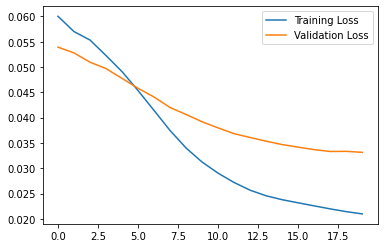

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

<h3>Definição de uma fronteira para classificação</h3>

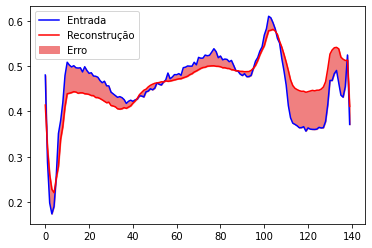

In [17]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Entrada", "Reconstrução", "Erro"])
plt.show()

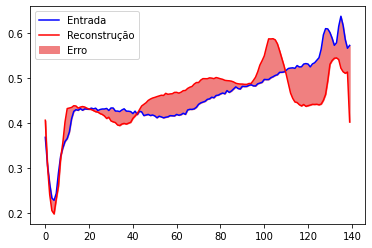

In [18]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Entrada", "Reconstrução", "Erro"])
plt.show()

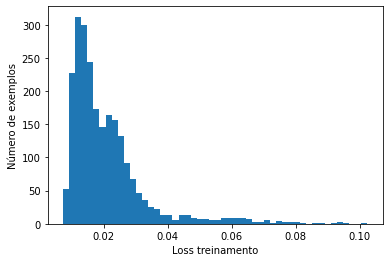

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Loss treinamento")
plt.ylabel("Número de exemplos")
plt.show()

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Fronteira: ", threshold)

Fronteira:  0.032831617


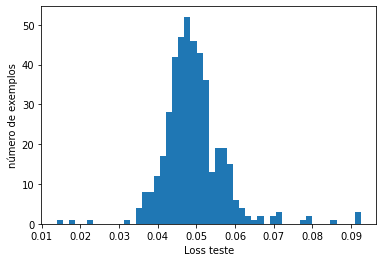

In [21]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Loss teste")
plt.ylabel("número de exemplos")
plt.show()

<h3>Validação do Classificador</h3>

In [22]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Acuracia = {}".format(accuracy_score(labels, predictions)))
  print("Precisão = {}".format(precision_score(labels, predictions)))
  print("Sensibilidade = {}".format(recall_score(labels, predictions)))

In [23]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Acuracia = 0.943
Precisão = 0.9921722113502935
Sensibilidade = 0.9053571428571429
